In [4]:
%pylab
%matplotlib inline 

Using matplotlib backend: MacOSX
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
import os

os.chdir("/Users/peter/dev/ucltrees/download/tls-tools-ucl/rxp-pipeline")

In [6]:
import glob
import ply_io
import pandas as pd
import geopandas as gp
from shapely.geometry import Point, Polygon
import string

from matplotlib.backends.backend_pdf import PdfPages

In [7]:
oko_01 = '/home/users/ucfacc2/TLS/gabon/OKO-01/2022-06-04.PROJ/'
oko_02 = '/home/users/ucfacc2/TLS/gabon/OKO-02/2022-06-10.PROJ/'
oko_03 = '/home/users/ucfacc2/TLS/gabon/OKO-03/2022-07-04.PROJ/'
lpg_01 = '/home/users/ucfacc2/TLS/gabon/LPG-01/2022-06-24.PROJ/'
fg5c1 = '/home/users/ucfacc2/TLS/fguiana/FG5c1/2022-10-10_FG5c1.PROJ/'
fg6c2 = '/home/users/ucfacc2/TLS/fguiana/FG6c2/2022-10-18_FG6c2.PROJ/'
fg8c4 = '/home/users/ucfacc2/TLS/fguiana/FG8c4/2022-09-26_FG8c4.PROJ/'

In [8]:
in_dir = oko_02
scratch_dir = '/work/scratch-pw3/ucfacc2/oko_02/'

In [9]:
def voxelise(tmp, length):

    tmp.loc[:, 'xx'] = tmp.x // length * length
    tmp.loc[:, 'yy'] = tmp.y // length * length
    
    code = lambda: ''.join(np.random.choice([x for x in string.ascii_letters], size=8))
    
    xD = {x:code() for x in tmp.xx.unique()}
    yD = {y:code() for y in tmp.yy.unique()}
    
    tmp.loc[:, 'VX'] = tmp.xx.map(xD) + tmp.yy.map(yD) 
    
    return tmp

def rigid_transform_2D(A, B):
    
    """
    http://nghiaho.com/uploads/code/rigid_transform_3D.py_
    """
    
    assert len(A) == len(B)
    
    A = np.matrixlib.defmatrix.matrix(A)
    B = np.matrixlib.defmatrix.matrix(B)

    N = A.shape[0]; # total points

    centroid_A = np.mean(A, axis=0).reshape(1, 2)
    centroid_B = np.mean(B, axis=0).reshape(1, 2)
    
    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))

    # dot is matrix multiplication for array
    H = np.transpose(AA) * BB

    U, S, Vt = np.linalg.svd(H)

    R = np.dot(Vt.T, U.T)
    
    t = -R*centroid_A.T + centroid_B.T
    
    M, N = np.identity(3), np.identity(3)
    M[:2, :2] = R
    N[:2, 2] = t.reshape(-1, 2)
    
    return np.dot(N, M)

In [11]:
def prepare_data(in_dir, matrix_dir, tile_index, 
                 plot=False, buffer=0, rotate=False, 
                 tile_size=20, MM=np.identity(3)):

    # read in scan positions
    L = glob.glob(os.path.join(matrix_dir, '*.dat')) + glob.glob(os.path.join(matrix_dir, '*.DAT'))
    sp = pd.DataFrame(columns=['sp', 'x', 'y'])

    for i, dat in enumerate(L):
        tmp = np.loadtxt(dat)[:2, 3]
        sp.loc[i, :] = [int(dat[-7:-4:])] + list(tmp) 
    
    # rotate using external matrix
    sp.loc[:, 'a'] = 1
    sp.loc[:, 'z'] = 1
    sp[['x', 'y']] = np.dot(MM, sp[['x', 'y', 'z', 'a']].T).T[:, :2]

    xoff = sp.loc[sp.sp == 1].x.item()
    yoff = sp.loc[sp.sp == 1].y.item()
    
    sp.x -= xoff
    sp.y -= yoff

    if len(sp) == 0: raise Exception(f'no scan positions at: {matrix_dir}')
        
    # rotate scan positions
    if rotate:
        spx = np.arange(1, 243)[::2]
        spx.reshape(11, 11)

        X, Y = np.meshgrid(np.arange(0, 110, 10), np.arange(0, 110, 10))

        spx = pd.DataFrame([spx, Y.flatten(), X.flatten()]).T
        spx.columns = ['sp', 'xx', 'yx']
        spx = pd.merge(spx, sp[['sp', 'x', 'y']], on='sp').astype(float)
        M = rigid_transform_2D(spx[['x', 'y']], spx[['xx', 'yx']], )
    else: M = np.identity(3)

    sp.loc[:, 'a'] = 1


    # transform to geopandas
    geometry = [Point(r.x, r.y) for r in sp.itertuples()]
    sp = gp.GeoDataFrame(sp, geometry=geometry)

    # and plot
    if plot:
        ax = sp.plot.scatter('x', 'y')
        ax.plot(*sp.unary_union.minimum_rotated_rectangle.exterior.xy, c='r', lw=5, zorder=1)
        
    # read in tile index
    ti = pd.read_csv(tile_index, sep=' ', usecols=[0,1,2,3], names=['tile', 'x', 'y', 'z'])
    ti.loc[:, 'z'] = 1
    ti.loc[:, 'a'] = 1

    # rotate using global matrix
    # ti[['x', 'y']] = np.dot(MM, ti[['x', 'y', 'z', 'a']].T).T[:, :2]
    
    # rotate with M
    ti.loc[:, 'a'] = 1
    ti[['x', 'y']] = np.dot(M, ti[['x', 'y', 'a']].T).T[:, :2]
    
    # ti.x -= xoff
    # ti.y -= yoff

    # convert to GeoPandas
    geometry = [Point(r.x, r.y) for r in ti.itertuples()]
    ti = gp.GeoDataFrame(ti, geometry=geometry)

    # split into a tile_size m grid
    ti = voxelise(ti, tile_size) # voxelise
    xx, yy = np.meshgrid(np.arange(ti.xx.min() - tile_size, ti.xx.max() + tile_size, tile_size), 
                         np.arange(ti.yy.min() - tile_size, ti.yy.max() + tile_size, tile_size))
    MAP = {vx:i for i, vx in enumerate(ti.sort_values(['xx', 'yy']).VX.unique())}
    ti.loc[:, 'quad'] = ti.VX.map(MAP)
        
    # generate grid boundaries
    print(np.vstack([xx.flatten(), yy.flatten()]).shape)
    quad_boundary = pd.DataFrame(data=np.vstack([xx.flatten(), yy.flatten()]).T, columns=['xx', 'yy'])
#     quad_boundary = ti.groupby('quad')[['xx', 'yy']].mean()

    polygons = []
    for row in quad_boundary.itertuples():
        polygons.append(Polygon([(row.xx - 0, row.yy - 0), 
                                 (row.xx + tile_size, row.yy - 0), 
                                 (row.xx + tile_size, row.yy + tile_size), 
                                 (row.xx - 0, row.yy + tile_size)]))

    quad_boundary = gp.GeoDataFrame({'geometry':polygons})

    # select only those that intersect plot boundary
    quad_boundary = quad_boundary.loc[quad_boundary.intersects(sp.unary_union.convex_hull.buffer(buffer))]
    quad_boundary.loc[:, 'quad_N'] = np.arange(len(quad_boundary))
    
    # select only tiles that intersect the quad boundary
    ti = ti.sjoin(quad_boundary)
    
    return sp, ti, quad_boundary, M, xoff, yoff

# in_dir = '/home/users/pwilkes/data/TLS/brazil/VCR-02/2019-07-15.001.riproject/'
matrix_dir = os.path.join(in_dir, 'matrix')
tile_index = os.path.join(in_dir, 'tile_index.dat')

# MM = np.array([  [0.999588, -0.028691, 604489.3],
#                 [0.028691, 0.999588, 648269.8],
                # [0.000000, 0.000000, 1.000000]])

MM = np.identity(4)
# MM = np.loadtxt('/home/users/pwilkes/data/TLS/gabon/FGC-04/2020-01-31.001.riproject/FGC04_post2pre.txt')

sp, ti, quad_boundary, M, xoff, yoff = prepare_data(in_dir, matrix_dir, tile_index, 
                                        buffer=3, rotate=False, tile_size=10, MM=MM)

# in_dir = '/home/users/pwilkes/data/TLS/gabon/FGC-01/2020-02-04.001.riproject/'
# matrix_dir = os.path.join(in_dir, 'raw', 'matrix')
# tile_index = os.path.join(in_dir, 'tile_index.dat')
# sp2, ti2, quad_boundary2 = prepare_data(in_dir, matrix_dir, tile_index)

ValueError: cannot set a frame with no defined index and a scalar

023,035,054,055,056,088,089,101,105,109,118,153,168,169,186,

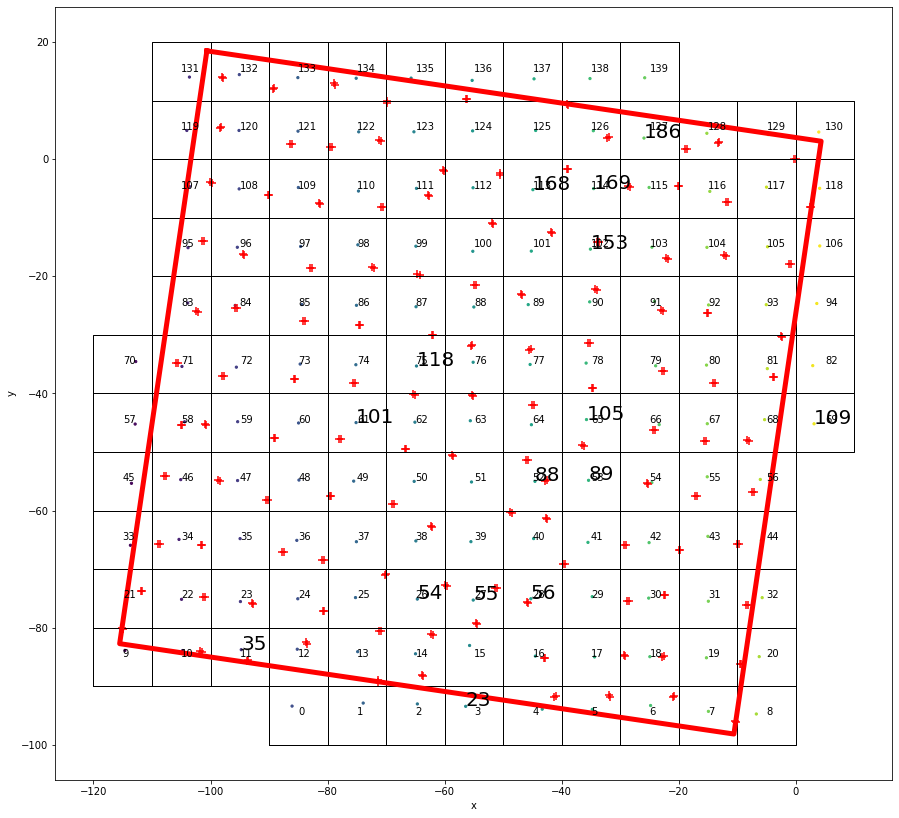

In [8]:
ax = ti.plot.scatter('x', 'y', c='quad', s=5, cmap='viridis', figsize=(15, 15), colorbar=False)
# [ax.text(r.x, r.y, r.tile, clip_on=True) for r in ti.itertuples()]
sp.plot.scatter('x', 'y', ax=ax, s=50, marker='+', c='r')
ax.plot(*sp.unary_union.minimum_rotated_rectangle.exterior.xy, c='r', lw=5, zorder=1)

quad_boundary.loc[quad_boundary.intersects(sp.unary_union.convex_hull.buffer(10))].plot(facecolor='none', ax=ax)
XXX = [ax.text(x, y, t) for x, y, t in zip(quad_boundary.centroid.x, 
                                           quad_boundary.centroid.y,                                           
                                           quad_boundary.quad_N)]

for row in ti.loc[ti.within(sp.unary_union.convex_hull.buffer(10))].sort_values('tile').itertuples():  
    if len(glob.glob(os.path.join(scratch_dir, f'clouds/*/{row.tile:03}_T*on.ply'))) == 0:        
        print(f'{row.tile:03}', end=',') 
#         print(f'{row.tile}', end=',') 
        ax.text(row.x, row.y, row.tile, clip_on=True, fontsize=20)

In [68]:
glob.glob(os.path.join(in_dir, f'tmp/*/{row.tile:03}_T*on.ply')

'/home/users/pwilkes/tmp/tmp/*/219_T*on.ply'

In [ ]:
os.path.isfile(False)

In [10]:
os.chdir('/home/users/pwilkes/data/TLS/gabon/LPG-01/2016-08-04.001.riproject/')

In [13]:
mosaic = """
    .C
    AA
    AA
    """

pp = PdfPages('/home/users/pwilkes/LPG01.plot-map.pdf')

# plt.style.use('classic')

for I, row in enumerate(sorted(quad_boundary.itertuples())):
    
#     if row.quad_N not in [22]: continue
    
    fig = plt.figure(figsize=(8.27, 11.69), facecolor='white')
    ax_dict = fig.subplot_mosaic(mosaic)
    
    ax = ax_dict['A']
    ax.set_facecolor('lightgrey')
    
    for tile in sorted(ti.loc[ti.within(row.geometry.buffer(6))].tile):
        
        for i, tree in enumerate(glob.glob(f'tmp/?.?/{tile:03}_T*on.ply')):
            
            tmp = ply_io.read_ply(tree)
            tmp = tmp.loc[tmp.wood == 1]
            tmp.loc[:, 'a'] = 1
            tmp[['x', 'y']] = np.dot(M, tmp[['x', 'y', 'a']].T).T[:, :2]
            
            tmp.z -= tmp.z.min()
            tmp = tmp.loc[tmp.z.between(2, 3)]
            if len(tmp) == 0: continue
            tmp.plot.scatter('x', 'y', marker='.',
                             c=f'C{np.random.randint(0, 255)}',
                             edgecolor='none',
                             s=5, ax=ax, 
                             zorder=3, clip_on=True)
            N = os.path.split(tree)[1].split('.')[0]
            ax.text(np.percentile(tmp.x, 95), 
                    np.percentile(tmp.y, 95), 
                    f'{N} : ......', clip_on=True)
            
#         t_slice = ply_io.read_ply(f'extraction/fsct/{tile:03}.downsample.segmented.ply')[['x', 'y', 'n_z', 'label']][::10]
#         t_slice = t_slice.loc[t_slice.n_z.between(2, 3)]
#         t_slice.plot.scatter('x', 'y', s=.1, c='grey', ax=ax, zorder=2)

    sp.loc[sp.sp%2 == 1].plot.scatter('x', 'y', ax=ax, s=100, lw=.5, c='r', marker='+')
    [ax.text(r.x + .25, r.y + .25, f'({r.x:.0f},{r.y:.0f})', 
             clip_on=True, style='italic', fontsize=8) for r in sp.loc[sp.sp%2 == 1].itertuples()]
        
    p = Polygon(sp.unary_union.minimum_rotated_rectangle.exterior)
    BOUNDS = gp.GeoDataFrame(index=[0], geometry=[p])
    BOUNDS.plot(ax=ax, facecolor='white', edgecolor='r', zorder=0)
    
    quad_boundary.plot(ax=ax, facecolor='none', ls='--', lw=.5, zorder=1)

    bounds = quad_boundary.loc[quad_boundary.quad_N == row.quad_N].bounds
    ax.set_xlim(bounds.minx.item() - 2, bounds.maxx.item() + 2)
    ax.set_ylim(bounds.miny.item() - 2, bounds.maxy.item() + 2)
    
    fig.text(.15, .7, f'{row.quad_N:02}', fontsize=150)

    ax = ax_dict['C']
#     ax.axis('off')

    ax.plot(*sp.unary_union.minimum_rotated_rectangle.exterior.xy, c='r', lw=1, zorder=1)
#     ax.plot(*sp.unary_union.minimum_rotated_rectangle.exterior.buffer(5).xy, c='r', lw=1, zorder=1)
    
    quad_boundary.loc[quad_boundary.intersects(sp.unary_union.convex_hull.buffer(5))].plot(facecolor='none', ax=ax, zorder=1)
    XXX = [ax.text(x, y, f'{t:02}', ha='center', va='center', clip_on=True) for x, y, t in zip(quad_boundary.centroid.x, 
                                               quad_boundary.centroid.y,
                                               quad_boundary.quad_N)]
    quad_boundary.loc[quad_boundary.quad_N == row.quad_N].plot(color='g', ax=ax, zorder=0)
    
    plt.savefig(pp, format='pdf', papertype='A4', bbox_inches='tight', pad_inches=.5)
    
#     break
    fig.clf()

#     if I == 3: break
    
pp.close()

/tmp/ipykernel_1574/2715231392.py:75: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(pp, format='pdf', papertype='A4', bbox_inches='tight', pad_inches=.5)
/tmp/ipykernel_1574/2715231392.py:75: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(pp, format='pdf', papertype='A4', bbox_inches='tight', pad_inches=.5)
/tmp/ipykernel_1574/2715231392.py:75: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(pp, format='pdf', papertype='A4', bbox_inches='tight', pad_inches=.5)
/tmp/ipykernel_1574/2715231392.py:75: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pape

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<Figure size 595.44x841.68 with 0 Axes>

<AxesSubplot:>

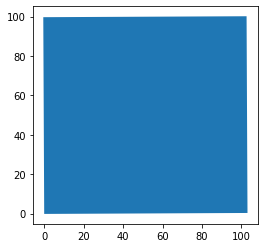

In [ ]:
t_slice = ply_io.read_ply(f'extraction/fsct/{tile:03}.downsample.segmented.ply')

In [242]:
t_slice

,x,y,z,n_z,label,pTerrain,pLeaf,pCWD,pWood,refl,dev,returnnumber,numberofreturns,sp
0,0.001087,0.008159,6.141824,7.642528,1.0,2.134474e-04,0.565071,5.936619e-04,0.434355,-17.849430,8.0,2.0,2.0,4.0
1,0.000624,0.008960,6.155936,7.656640,1.0,2.134474e-04,0.580842,5.936619e-04,0.418584,-14.106901,0.0,2.0,2.0,36.0
2,0.018685,0.005689,8.424848,9.925552,1.0,6.670832e-04,0.700879,1.346367e-03,0.299002,-3.830694,1.0,1.0,1.0,44.0
3,0.014830,0.001338,8.434098,9.934802,1.0,3.906435e-04,0.654240,1.017259e-03,0.345403,-7.630785,1.0,1.0,2.0,43.0
4,0.019925,0.016640,14.516026,16.016731,1.0,4.671420e-04,0.769155,7.689629e-04,0.230614,-15.350503,5.0,1.0,2.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516610,9.996228,9.998403,7.659415,13.158697,1.0,7.997727e-05,0.785935,5.782910e-04,0.213154,-17.251310,5.0,1.0,1.0,4.0
2516611,9.981854,9.982386,7.935742,13.435023,1.0,2.489057e-04,0.905957,1.393002e-03,0.089537,-18.354979,2.0,1.0,2.0,6.0
2516612,9.984690,9.997155,8.196441,13.695722,1.0,3.616375e-05,0.918229,7.665435e-04,0.080985,-14.474897,4.0,1.0,2.0,6.0
2516613,9.987462,9.989606,55.503517,61.002799,3.0,8.555830e-09,0.070942,3.773021e-07,0.929058,-11.647905,3.0,1.0,2.0,40.0


<AxesSubplot:xlabel='x', ylabel='y'>

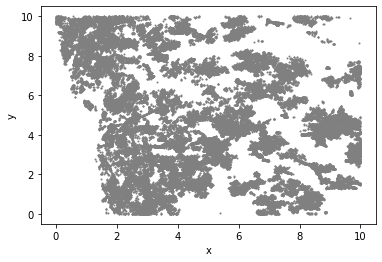

In [235]:
t_slice.plot.scatter('x', 'y', s=1, c='grey')

In [135]:
bounds = quad_boundary.loc[quad_boundary.quad_N == 20].bounds

In [136]:
bounds.minx.item()

-30.0

(-72.0, -48.0)

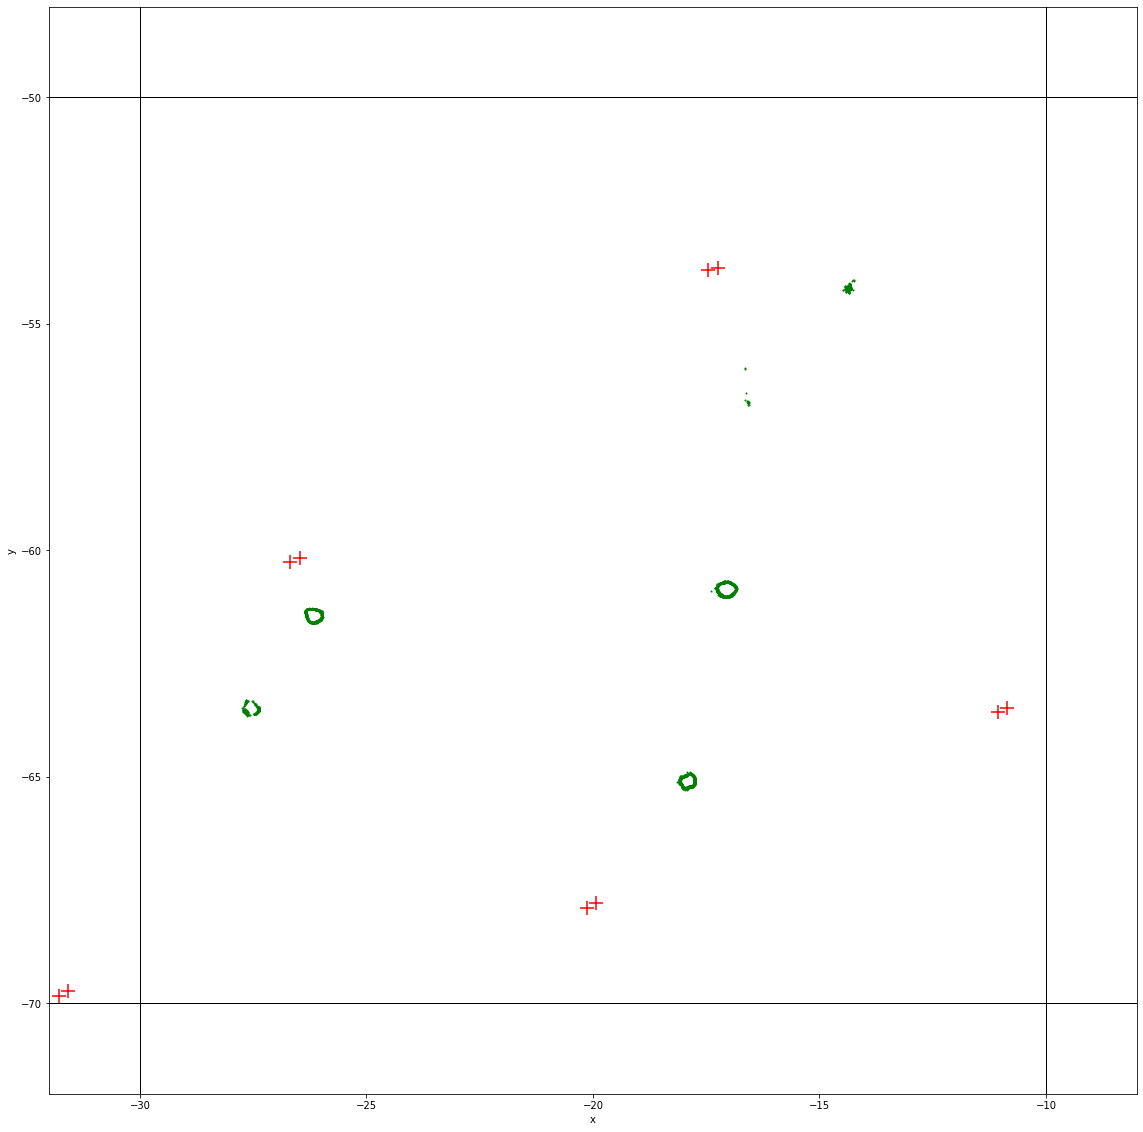

In [139]:
ax = trees.loc[trees.z.between(1.3, 1.4)].plot.scatter('x', 'y', 
                                                       c='g', 
                                                       figsize=(20, 20), 
                                                       colorbar=False, s=1)


In [161]:
xmin, ymin, xmax, ymax = quad_boundary.total_bounds

length = 20

cols = list(np.arange(xmin, xmax + length, length))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+length, y), (x+length, y+length), (x, y+length)]))

grid = gp.GeoDataFrame({'geometry':polygons})
grid.loc[:, 'N'] = np.arange(len(grid))

AttributeError: 'DataFrame' object has no attribute 'total_bounds'